In [6]:
from IPython.display import display, HTML

def visualize_single_neuron(words, cell_states, neuron_index):
    """
    Colorizes text based on the activation of a single neuron.
    Red = Positive Memory, Blue = Negative Memory
    """
    activations = cell_states[:, neuron_index]

    # Normalize to -1 to 1 for better color visualization
    max_val = np.max(np.abs(activations))
    norm_activations = activations / max_val

    html_str = '<div style="font-family: monospace; font-size: 20px;">'

    for word, act in zip(words, norm_activations):
        # Calculate color: Red (positive) or Blue (negative)
        if act > 0:
            color = f"rgba(255, 0, 0, {abs(act)})" # Red with opacity
        else:
            color = f"rgba(0, 0, 255, {abs(act)})" # Blue with opacity

        html_str += f'<span style="background-color: {color}; padding: 2px; margin: 1px;">{word}</span> '

    html_str += '</div>'

    display(HTML(f"<b>Visualizing Neuron #{neuron_index}:</b>"))
    display(HTML(html_str))

# Usage (Run this after the previous code block):
# Check what Neuron 5 is thinking about


--- Starting Training (300 Epochs) ---
Epoch 50/300 | Loss: 0.0026
Epoch 100/300 | Loss: 0.0010
Epoch 150/300 | Loss: 0.0007
Epoch 200/300 | Loss: 0.0005
Epoch 250/300 | Loss: 0.0003
Epoch 300/300 | Loss: 0.0003

--- Test Results ---
Model Prediction sequence: quick brown fox jumps over a lazy dog.

Generating Memory Heatmap...


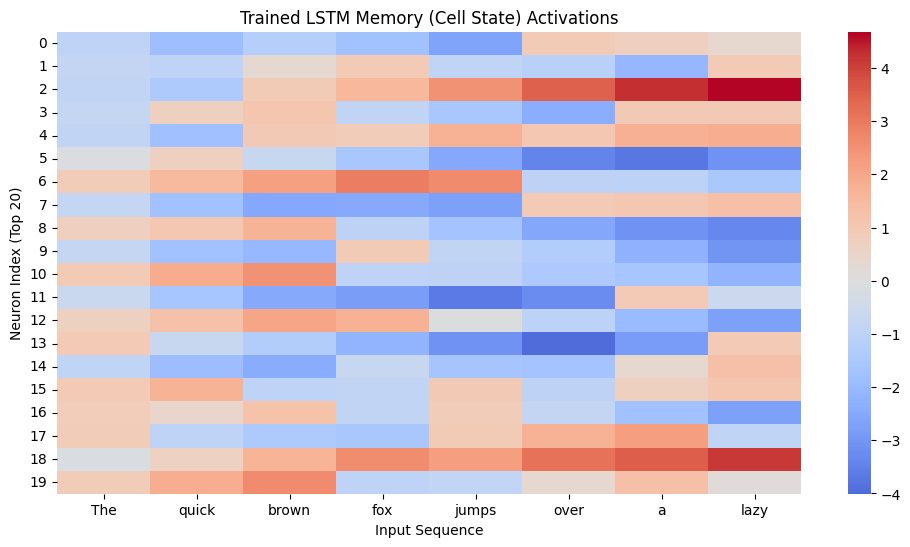

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class LSTMSentenceExperiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTMSentenceExperiment, self).__init__()

        # 1. Embedding: Converts word index (e.g., 2) to a vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. LSTM: The core memory unit
        # batch_first=True means input shape is (Batch, Seq_Len, Features)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

        # 3. Linear: Decodes LSTM output to a prediction of the next word
        self.fc = nn.Linear(hidden_size, vocab_size)

        self.hidden_size = hidden_size

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        embeds = self.embedding(x)

        # out shape: (batch_size, seq_len, hidden_size)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # predict shape: (batch_size, seq_len, vocab_size)
        prediction = self.fc(lstm_out)
        return prediction, hidden

    def train_model(self, input_seq, target_seq, epochs=300):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.01)

        print(f"--- Starting Training ({epochs} Epochs) ---")
        for epoch in range(epochs):
            optimizer.zero_grad()

            # Forward pass
            # We initialize hidden state to None (zeros) automatically
            output, _ = self.forward(input_seq)

            # Flatten output for CrossEntropy: (Batch*Seq, Vocab_Size)
            loss = criterion(output.view(-1, output.shape[-1]), target_seq.view(-1))

            loss.backward() # back propagation of gradients
            optimizer.step() # update params

            if (epoch+1) % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

    def test_prediction(self, input_seq, idx_to_word):
        """
        Runs the trained model on the input to see if it predicts the next words correctly.
        """
        self.eval() # Set to evaluation mode
        with torch.no_grad():
            output, _ = self.forward(input_seq)
            # Get the index of the highest probability for each step
            predicted_indices = torch.argmax(output, dim=2).squeeze().tolist()

        print("\n--- Test Results ---")
        predicted_words = [idx_to_word[idx] for idx in predicted_indices]
        print(f"Model Prediction sequence: {' '.join(predicted_words)}")
        return predicted_words

    def get_cell_states(self, inputs):
        """
        Runs the input through the LSTM and captures the Cell State (Memory)
        at every time step.
        """
        # Reset hidden/cell state
        h_t = torch.zeros(1, 1, self.hidden_size)
        c_t = torch.zeros(1, 1, self.hidden_size)

        cell_states = []

        # Manual loop to capture cell state at every step
        # inputs shape: (1, seq_len, input_size)
        for i in range(inputs.size(1)):
            step_input = inputs[:, i:i+1, :]
            output, (h_t, c_t) = self.lstm(step_input, (h_t, c_t))

            # Store the cell state (memory) for this step
            # c_t shape is (1, 1, hidden_size) -> flatten to vector
            cell_states.append(c_t.detach().numpy().flatten())

        return np.array(cell_states)

    def visualize_memory(self, input_seq, idx_to_word):
        """
        Feeds input, captures Cell State (Long-term memory), and plots heatmap.
        """
        self.eval()
        with torch.no_grad():
            embeds = self.embedding(input_seq)

            # We process step by step to capture memory states
            h_t = torch.zeros(1, 1, self.hidden_size)
            c_t = torch.zeros(1, 1, self.hidden_size)

            cell_states = []

            for i in range(embeds.size(1)):
                step_input = embeds[:, i:i+1, :]
                _, (h_t, c_t) = self.lstm(step_input, (h_t, c_t))

                # c_t is the "Cell State" (The internal conveyor belt memory)
                # (1, 1, hidden_size) -> after flatten -> (hidden_Size)
                cell_states.append(c_t.numpy().flatten())

        # Plotting
        cell_states = np.array(cell_states)
        words = [idx_to_word[idx.item()] for idx in input_seq.squeeze()]

        plt.figure(figsize=(12, 6))
        # Plot first 20 neurons
        sns.heatmap(cell_states.T[:20, :], xticklabels=words, cmap="coolwarm", center=0)
        plt.title("Trained LSTM Memory (Cell State) Activations")
        plt.xlabel("Input Sequence")
        plt.ylabel("Neuron Index (Top 20)")
        plt.yticks(rotation=0)
        plt.show()

# --- PREPARATION & EXECUTION ---

# 1. Data Setup
text = "The quick brown fox jumps over a lazy dog."
words = text.split()

# Create a simple vocabulary mapping
vocab = sorted(list(set(words)))
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for i, w in enumerate(vocab)}

# Convert text to indices
# Input: "The quick brown ..."
# Target: "quick brown fox ..." (Next word prediction)
seq_indices = [word_to_idx[w] for w in words]
input_tensor = torch.tensor([seq_indices[:-1]], dtype=torch.long) # Exclude last word
target_tensor = torch.tensor([seq_indices[1:]], dtype=torch.long) # Exclude first word

# 2. Initialize Model
vocab_size = len(vocab)
embed_dim = 10
hidden_size = 50

model = LSTMSentenceExperiment(vocab_size, embed_dim, hidden_size)

# 3. Train
model.train_model(input_tensor, target_tensor)

# 4. Test
model.test_prediction(input_tensor, idx_to_word)

# 5. Visualize
print("\nGenerating Memory Heatmap...")
model.visualize_memory(input_tensor, idx_to_word)

In [8]:
words = ["The", "quick", "brown", "fox", "jumps", "over", "a", "lazy", "dog"]
# Create random vectors to represent these words
inputs = torch.randn(1, len(words), 10)
memory_history = model.get_cell_states(inputs)

In [12]:
visualize_single_neuron(words, memory_history, neuron_index=6)

## C++ Input example


In [ ]:
cpp_code = """#include <iostream>

// Function 1: Adds two integers
int add(int a, int b) {
    return a + b;
}

// Function 2: Multiplies two integers
int multiply(int a, int b) {
    return a * b;
}

// Function 3: Main function
int main() {
    std::cout << "Hello from C++!" << std::endl;
    int sum = add(5, 3);
    int product = multiply(5, 3);
    std::cout << "Sum: " << sum << std::endl;
    std::cout << "Product: " << product << std::endl;
    return 0;
}
"""

print("C++ code snippet defined and assigned to 'cpp_code' variable.")

C++ code snippet defined and assigned to 'cpp_code' variable.


## Tokenize C++ Code

### Subtask:
Tokenize the defined C++ code into individual 'words' or tokens. This will involve splitting the code by spaces and potentially handling punctuation or special characters.


In [ ]:
import re

# Corrected and more comprehensive regex pattern for C++ tokens.
# The order is crucial: more specific/longer matches should come before more general/shorter ones.
# Each alternative is wrapped in a non-capturing group (?:...) to ensure re.findall returns a flat list of matches.
token_pattern = re.compile(r"""
    (?:/\*[\s\S]*?\*/)                      # 1. Multi-line comments
    | (?://[^\n]*)                          # 2. Single-line comments
    | (?:\"(?:\\.|[^\"\\])*\")              # 3. String literals (handles escaped quotes)
    | (?:\bstd::\b)                         # 4. 'std::' namespace prefix
    | (?:\#)                                # 5. Preprocessor directive start '#'
    | (?:<<=|>>=|->\*|<=|>=|==|!=|&&|\|\||\+\+|--|::|\+=|-=|\*=|/=|%=|&=|\|=|\^=|~=) # 6. Multi-character operators/punctuators
    | (?:[+*%=<>!&|^~?:;,\.(){}\[\]-])     # 7. Single-character operators/punctuators (placed before keywords/identifiers, '-' moved to end)
    | (?:                              # 8. C++ Keywords (a fairly comprehensive list)
        \b(?:auto|break|case|catch|char|class|const|continue|default|delete|do|double|else|enum|extern|float|for|friend|goto|if|inline|int|long|mutable|namespace|new|operator|private|protected|public|register|return|short|signed|sizeof|static|struct|switch|template|this|throw|try|typedef|union|unsigned|using|virtual|void|volatile|while|bool|concept|const_cast|constexpr|decltype|dynamic_cast|explicit|export|final|import|module|noexcept|nullptr|override|private|protected|public|reinterpret_cast|requires|static_assert|static_cast|thread_local|typeid|typename)\b
      )
    | (?:\b\d+\.\d*(?:[eE][+\-]?\d+)?\b)    # 9. Floating-point numbers
    | (?:\b\d+\b)                           # 10. Integer numbers
    | (?:\b[a-zA-Z_]\w*\b)                  # 11. Identifiers (must be after keywords and numbers)
""", re.VERBOSE)

# Apply the compiled pattern to find all matches.
# With all alternatives as non-capturing groups, findall returns a flat list of strings.
cpp_tokens = token_pattern.findall(cpp_code)

# Filter out any empty strings that might result from trailing whitespace (though less likely with this pattern)
# and strip any remaining whitespace from tokens.
cpp_tokens = [token.strip() for token in cpp_tokens if token.strip()]

print(f"Original C++ code length: {len(cpp_code)} characters")
print(f"Number of tokens extracted: {len(cpp_tokens)}")
print("First 30 tokens:")
print(cpp_tokens[:30])
print("\nLast 10 tokens:")
print(cpp_tokens[-10:])


Original C++ code length: 454 characters
Number of tokens extracted: 105
First 30 tokens:
['#', 'include', '<', 'iostream', '>', '// Function 1: Adds two integers', 'int', 'add', '(', 'int', 'a', ',', 'int', 'b', ')', '{', 'return', 'a', '+', 'b', ';', '}', '// Function 2: Multiplies two integers', 'int', 'multiply', '(', 'int', 'a', ',', 'int']

Last 10 tokens:
['product', '<', '<', 'std::', 'endl', ';', 'return', '0', ';', '}']


## Create Token Embeddings

### Subtask:
Generate unique numerical embeddings for each C++ code token, ensuring each embedding is a 10-dimensional vector, and then create a sequence of these embeddings corresponding to the `cpp_tokens` list, storing the result as a PyTorch tensor.


In [ ]:
import numpy as np
import torch

# 1. Identify all unique tokens
unique_tokens = sorted(list(set(cpp_tokens)))

# 2. For each unique token, generate a random 10-dimensional numerical embedding
embedding_dim = 10
token_to_embedding = {
    token: np.random.randn(embedding_dim).astype(np.float32) for token in unique_tokens
}

# 3. Iterate through the original cpp_tokens list and retrieve the corresponding embedding for each token
# 4. Collect these embeddings into a list
embeddings_list = [token_to_embedding[token] for token in cpp_tokens]

# 5. Convert the list of embeddings into a PyTorch tensor
# Ensure the tensor has the shape (1, sequence_length, embedding_dimension)
inputs = torch.tensor(np.array(embeddings_list)).unsqueeze(0)

print(f"Number of unique tokens: {len(unique_tokens)}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Shape of the input embeddings tensor (inputs): {inputs.shape}")
print("Example embedding for 'int':")
print(token_to_embedding.get('int', 'Not found'))

Number of unique tokens: 35
Embedding dimension: 10
Shape of the input embeddings tensor (inputs): torch.Size([1, 105, 10])
Example embedding for 'int':
[ 2.206858   -0.28395197 -0.8664231  -0.32442048  0.8794987   2.6733103
 -1.1438382  -1.3064352   0.55237454 -1.416301  ]


## Process with LSTM and Visualize

### Subtask:
Process the token embeddings using the `LSTMVisualizer` to capture cell states, then generate a heatmap visualization of all neurons and a visualization for a single neuron.


**Reasoning**:
I will instantiate the `LSTMVisualizer`, get the cell states from the token embeddings, and then generate both the heatmap and single neuron visualizations as requested in the subtask.



In [5]:
print("Processing C++ token embeddings with LSTM and visualizing results...")

# 1. Instantiate the LSTMVisualizer class
viz = LSTMVisualizer(input_size=embedding_dim, hidden_size=50)

# 2. Get cell states from the token embeddings
memory_history = viz.get_cell_states(inputs)

# 3. Generate a heatmap visualization of all neurons
viz.plot_heatmap(cpp_tokens, memory_history)

# 4. Visualize a single neuron
visualize_single_neuron(cpp_tokens, memory_history, neuron_index=13)

Processing C++ token embeddings with LSTM and visualizing results...


NameError: name 'LSTMVisualizer' is not defined

In [ ]:
visualize_single_neuron(cpp_tokens, memory_history, neuron_index=9)